In [9]:
# Install
!pip3 install h3pandas
!pip3 install geopandas
!pip3 install gtfs_functions
#!pip3 install gtfs_kit
!pip3 install folium
!pip3 install shapely
#!pip3 install mpu

In [10]:
# Import
import geopandas as gpd
import h3pandas
import pandas as pd
from google.colab import drive # For Google Colab
import os
import gtfs_functions as gtfs
import folium
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import shapely
import numpy as np
#from branca.element import Figure
#import h3

In [11]:
drive.mount('/content/drive',force_remount=True)
working_dir = '/content/drive/MyDrive/Projects/SE_soft_mobility_project/Stockholm_project/Deliverables'
source_dir = '/content/drive/MyDrive/Projects/SE_soft_mobility_project/Stockholm_project/Sources'
os.chdir(working_dir)

NameError: name 'drive' is not defined

## Creation datasets from raw data to parquet

In [ ]:
# Create datasets from raw data to parquet
os.chdir(source_dir)
# Original dataset of RegSo for Sweden CRS: empty
regso = gpd.read_parquet('/content/drive/MyDrive/Projects/SE_soft_mobility_project/z_RegSo/RegSO_2018_NEW.parquet')
regso = regso.query('kommunnamn == "Stockholm"').drop(columns='sweref')[['regso','kommunnamn','geometry']]
regso.geometry = regso.geometry.set_crs(4326)

# Original dataset of Cycle network of Stockholm. CRS: EPSG:3011 SWEREF99
cycle = gpd.read_file('Data/Cykelstrak_Linje.gpkg') 
cycle = cycle.to_crs(4326) #CRS: EPSG:4326 WGS 84
cycle.columns = cycle.columns.str.lower()
cycle = cycle[['object_id','main_attribute_value','cid','geometry']].set_index('object_id', drop=True)
cycle = gpd.clip(cycle, regso) # Cliping cycle routes by the area of interest

# Original dataset of Stockholm districts, without waterobjects CRS: EPSG:4326 WGS 84
city_w = gpd.read_file('Data/Naturliga_avrinningsomrA5den_dagvatten_(vattenfB6rekomst).geojson') 
city_w.columns = city_w.columns.str.lower()
#cycle = cycle[['object_id','main_attribute_value','cid','geometry']].set_index('object_id', drop=True)
city_uu = city_w.geometry.unary_union

# CRS: EPSG:4326 WGS 84
districts = regso
districts.geometry = districts.geometry.intersection(city_uu) # RegSo without waterobjects

# Original dataset GTFS for Stockholm. расчитываем кол-во автобусов проходящих на каждой остановке в час (max_freq) и для интервала/window (frequency)
path = 'Data/sl.zip'
# Read dataset
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(path)
# Create dataframe from GTFS data
cutoffs = [0,24] # get daily bus and train frequencies  
gtfs_stop_freq = gtfs.stops_freq(stop_times, stops, cutoffs = cutoffs)
# Сопоставляем stop_id и route_type (Railway Service,Bus Service,Communal Taxi Service)
route_type = stop_times[['route_id','stop_id','stop_name']]
route_type = route_type.merge(routes[['route_id','route_type']]).drop(columns=['route_id','stop_name']).drop_duplicates()
# Добавляем к gtfs_stop_freq column route_type
gtfs_stop_freq = pd.merge(gtfs_stop_freq, route_type, on="stop_id")
# Оставляем в gtfs_stop_freq только остановки входящие в Kalmar districts
stop_freq_stockholm = gpd.clip(gtfs_stop_freq, districts) # Clip stops from the area of interest
# Рассчитываем среднее кол-во автобусов проходящих на каждой остановке в час (avg_freq)
stop_freq_stockholm['avg_freq'] = (stop_freq_stockholm.ntrips * stop_freq_stockholm.frequency)/24
# Сортируем по убыванию (avg_freq) и удаляем дубликаты 'geometry'

### ВОЗМОЖНО СТОИТ УДАЛЯТЬ ПОСЛЕ ДЕЛЕНИЯ НА ТИПЫ ТРАНСПОРТА
#stop_freq_stockholm = stop_freq_stockholm.sort_values('avg_freq',ascending=False)
#stop_freq_stockholm = stop_freq_stockholm.drop_duplicates('geometry')

# Выгружаем обработанные датасеты в папку working_dir (parquet)
os.chdir(working_dir) # Return to working_dir
districts.to_parquet('Data/districts.parquet')
stop_freq_stockholm.to_parquet('Data/stop_freq_stockholm.parquet')
cycle.to_parquet('Data/cycle.parquet')

## Creation dataset of features for Stockholm

Upload datasets of Districts and stops of Stockholm

In [ ]:
# Upload datasets of Districts and stops of Stockholm
os.chdir(working_dir) # Return to working_dir
districts = gpd.read_parquet('Data/districts.parquet')
stop_freq_stockholm = gpd.read_parquet('Data/stop_freq_stockholm.parquet').to_crs(4326)
cycle = gpd.read_parquet('Data/cycle.parquet')

Manipulations with datasets for creating features

In [ ]:
# Делим датачет на несколько датасетов с разными типами велодорожек
cycle_reg = cycle.query('main_attribute_value == "Regionalt cykelstråk"').copy() # 11888 / 6441 linestring
cycle_main = cycle.query('main_attribute_value == "Huvudnät"').copy() # 6441 / 6230 linestring
cycle_primary = cycle.query('main_attribute_value == "Primärt stråk"').copy() # 6231 / 5662 linestring
#cycle_ungefärligt_huvudnät = cycle.query('main_attribute_value == "Ungefärligt huvudnät"')
#cycle_ungefärligt_primärt_stråk = cycle.query('main_attribute_value == "Ungefärligt primärt stråk"')
#cycle_strategisk_koppling = cycle.query('main_attribute_value == "Strategisk koppling"')

In [ ]:
# Делим таблицу на несколько таблиц by Route Types 
types = list(stop_freq_stockholm.route_type.unique())
# Доработать логику авто определения типа и создания отдельных df
railway_stop = stop_freq_stockholm.query('route_type == 100').copy() # (Railway Service - 100)
railway_stop_mean = railway_stop.groupby(['stop_id']).mean()
railway_stop = railway_stop.set_index('stop_id',drop=True)[['stop_name','geometry']]
railway_stop = railway_stop.join(railway_stop_mean).drop_duplicates()
bus_stop = stop_freq_stockholm.query('route_type == 700').copy() # (Bus Service - 700)
bus_stop_mean = bus_stop.groupby(['stop_id']).mean()
bus_stop = bus_stop.set_index('stop_id',drop=True)[['stop_name','geometry']]
bus_stop = bus_stop.join(bus_stop_mean).drop_duplicates()
metro_stop = stop_freq_stockholm.query('route_type == 401').copy() # (Metro Service - 401)
metro_stop_mean = metro_stop.groupby(['stop_id']).mean()
metro_stop = metro_stop.set_index('stop_id',drop=True)[['stop_name','geometry']]
metro_stop = metro_stop.join(metro_stop_mean).drop_duplicates()
tram_stop = stop_freq_stockholm.query('route_type == 900').copy() # (Tram Service - 900)
tram_stop_mean = tram_stop.groupby(['stop_id']).mean()
tram_stop = tram_stop.set_index('stop_id',drop=True)[['stop_name','geometry']]
tram_stop = tram_stop.join(tram_stop_mean).drop_duplicates()
wts_stop = stop_freq_stockholm.query('route_type == 1000').copy() # (Water Transport Service - 1000)
wts_stop_mean = wts_stop.groupby(['stop_id']).mean()
wts_stop = wts_stop.set_index('stop_id',drop=True)[['stop_name','geometry']]
wts_stop = wts_stop.join(wts_stop_mean).drop_duplicates()

In [ ]:
# Create h3 hexagons for RegSo zones and districts (127)
resolution = 10
#regso_h3 = regso.h3.polyfill(resolution, explode=True).drop(columns=['version','sweref','geometry'])
#regso_h3 = regso_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary() # length 86332  # Не работает если есть h3 Nan

# Добавляем к gtfs_stop_freq column h3
#gtfs_stop_h3 = gtfs_stop_freq.h3.geo_to_h3(resolution, set_index=False)

# После polyfill df содержит дубли h3 которые принадлежат к разным districts, нужен drop_duplicates
districts_h3 = districts.h3.polyfill(resolution, explode=True).drop(columns=['geometry']).drop_duplicates('h3_polyfill')
districts_h3 = districts_h3.dropna(subset =['h3_polyfill']).set_index('h3_polyfill').h3.h3_to_geo_boundary()

In [ ]:
# Plot optimisational grid h3 for districts
ax = districts_h3.plot(figsize=(21, 14), column='kommunnamn')
ax.set_title('Division of Stockholm into districts (127 entries)')
ax.axis('off')

In [ ]:
# Для определения растояний от центров h3 до ближайшей остановки нужен h3 centroid
# EPSG:3006 SWEREF99 TM
crsp = 3006
unit='km' # For distance calculation
#districts_h3['centroid_32633'] = districts_h3.geometry.to_crs(32633).centroid  # НЕ нужно для h3 point_dist и mpu.haversine_distance
districts_h3['centroid'] = districts_h3.geometry.to_crs(crsp).centroid
districts_h3_centroid = districts_h3[['centroid']].set_geometry('centroid')


# Sjoin_nearest for railway stops and h3 centroid
# Calculate distance from h3.centroid to nearest railway stop with h3.point_dist in m.
railway_stop = railway_stop.to_crs(crsp)
railway_stop['geom'] = railway_stop.geometry
districts_h3_dist_railway = (gpd.sjoin_nearest
                             (districts_h3_centroid, railway_stop,how='left',distance_col='dist_r')
                             .rename(columns={'avg_freq':'avg_freq_r'})
                             .sort_values('avg_freq_r')) # ЭТОТ ВАРИАНТ ЛУЧШЕ
# Calculate distance from h3.centroid to nearest railway stop with h3.point_dist in m.
# Gives the "great circle" or "haversine" distance between pairs of GeoCoord points (lat/lng pairs) in meters.
#districts_h3_dist_railway = districts_h3_dist_railway.to_crs(4326).rename(columns={'avg_freq':'avg_freq_r'}) # To properly calculate the distance
#districts_h3_dist_railway.geom = districts_h3_dist_railway.geom.to_crs(4326) # To properly calculate the distance
#districts_h3_dist_railway['dist_r'] = (districts_h3_dist_railway.apply
#                             (lambda row: (h3.point_dist((row['centroid'].x,row['centroid'].y),
#                                                         (row['geom'].x,row['geom'].y), unit=unit)),axis=1))
h3_dist_railway = (districts_h3_dist_railway[['avg_freq_r','dist_r']]
                   .reset_index().drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))
# Sjoin_nearest for bus stops and h3 centroid
bus_stop = bus_stop.to_crs(crsp)
bus_stop['geom'] = bus_stop.geometry
districts_h3_dist_bus = (gpd.sjoin_nearest
                             (districts_h3_centroid, bus_stop,how='inner',distance_col='dist_b')
                             .rename(columns={'avg_freq':'avg_freq_b'})
                             .sort_values('avg_freq_b'))
# Calculate distance from h3.centroid to nearest bus_stop with h3.point_dist in km.
# Gives the "great circle" or "haversine" distance between pairs of GeoCoord points (lat/lng pairs) in meters.
#districts_h3_dist_bus = districts_h3_dist_bus.to_crs(4326).rename(columns={'avg_freq':'avg_freq_b'})
#districts_h3_dist_bus.geom = districts_h3_dist_bus.geom.to_crs(4326) 
#districts_h3_dist_bus['dist_b'] = (districts_h3_dist_bus.apply
#                             (lambda row: (h3.point_dist((row['centroid'].x,row['centroid'].y),
#                                                         (row['geom'].x,row['geom'].y), unit=unit)),axis=1))
h3_dist_bus = (districts_h3_dist_bus[['avg_freq_b','dist_b']]
               .reset_index().drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))
# Sjoin_nearest for metro stops and h3 centroid
metro_stop = metro_stop.to_crs(crsp)
metro_stop['geom'] = metro_stop.geometry
districts_h3_dist_metro = (gpd.sjoin_nearest
                             (districts_h3_centroid, metro_stop,how='inner',distance_col='dist_m')
                             .rename(columns={'avg_freq':'avg_freq_m'})
                             .sort_values('avg_freq_m'))
# Calculate distance from h3.centroid to nearest metro stop with h3.point_dist in km.
# Gives the "great circle" or "haversine" distance between pairs of GeoCoord points (lat/lng pairs) in meters.
#districts_h3_dist_metro = districts_h3_dist_metro.to_crs(4326).rename(columns={'avg_freq':'avg_freq_m'})
#districts_h3_dist_metro.geom = districts_h3_dist_metro.geom.to_crs(4326)
#districts_h3_dist_metro['dist_m'] = (districts_h3_dist_metro.apply
#                             (lambda row: (h3.point_dist((row['centroid'].x,row['centroid'].y),
#                                                         (row['geom'].x,row['geom'].y), unit=unit)),axis=1))
h3_dist_metro = (districts_h3_dist_metro[['avg_freq_m','dist_m']]
                 .reset_index().drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))
# Sjoin_nearest for tram stops and h3 centroid
tram_stop = tram_stop.to_crs(crsp)
tram_stop['geom'] = tram_stop.geometry
districts_h3_dist_tram = (gpd.sjoin_nearest
                             (districts_h3_centroid, tram_stop,how='inner',distance_col='dist_t')
                             .rename(columns={'avg_freq':'avg_freq_t'})
                             .sort_values('avg_freq_t'))
# Calculate distance from h3.centroid to nearest tram stop with h3.point_dist in km.
# Gives the "great circle" or "haversine" distance between pairs of GeoCoord points (lat/lng pairs) in meters.
#districts_h3_dist_tram = districts_h3_dist_tram.to_crs(4326).rename(columns={'avg_freq':'avg_freq_t'})
#districts_h3_dist_tram.geom = districts_h3_dist_tram.geom.to_crs(4326)
#districts_h3_dist_tram['dist_t'] = (districts_h3_dist_tram.apply
#                             (lambda row: (h3.point_dist((row['centroid'].x,row['centroid'].y),
#                                                         (row['geom'].x,row['geom'].y), unit=unit)),axis=1))
h3_dist_tram = (districts_h3_dist_tram[['avg_freq_t','dist_t']]
                .reset_index().drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))
# Sjoin_nearest for wts stops and h3 centroid
wts_stop = wts_stop.to_crs(crsp)
wts_stop['geom'] = wts_stop.geometry
districts_h3_dist_wts = (gpd.sjoin_nearest
                             (districts_h3_centroid, wts_stop,how='inner',distance_col='dist_wts')
                             .rename(columns={'avg_freq':'avg_freq_wts'})
                             .sort_values('avg_freq_wts'))
# Calculate distance from h3.centroid to nearest tram stop with h3.point_dist in km.
# Gives the "great circle" or "haversine" distance between pairs of GeoCoord points (lat/lng pairs) in meters.
#districts_h3_dist_wts = districts_h3_dist_wts.to_crs(4326).rename(columns={'avg_freq':'avg_freq_wts'})
#districts_h3_dist_wts.geom = districts_h3_dist_wts.geom.to_crs(4326)
#districts_h3_dist_wts['dist_wts'] = (districts_h3_dist_wts.apply
#                             (lambda row: (h3.point_dist((row['centroid'].x,row['centroid'].y),
#                                                         (row['geom'].x,row['geom'].y), unit=unit)),axis=1))
h3_dist_wts = (districts_h3_dist_wts[['avg_freq_wts','dist_wts']]
               .reset_index().drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))


In [ ]:
cycle_reg = cycle_reg.to_crs(crsp)
cycle_reg['geom'] = cycle_reg.geometry
districts_h3_dist_cycle_reg = (gpd.sjoin_nearest
                             (districts_h3_centroid, cycle_reg,how='inner',distance_col='dist_creg'))
h3_dist_cycle_reg = (districts_h3_dist_cycle_reg[['dist_creg']].reset_index()
                    .drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))

cycle_main = cycle_main.to_crs(crsp)
cycle_main['geom'] = cycle_main.geometry
districts_h3_dist_cycle_main = (gpd.sjoin_nearest
                             (districts_h3_centroid, cycle_main,how='inner',distance_col='dist_c_m'))
h3_dist_cycle_main = (districts_h3_dist_cycle_main[['dist_c_m']].reset_index()
                    .drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))

cycle_primary = cycle_primary.to_crs(crsp)
cycle_primary['geom'] = cycle_primary.geometry
districts_h3_dist_cycle_primary = (gpd.sjoin_nearest
                             (districts_h3_centroid, cycle_primary,how='inner',distance_col='dist_cpri'))
h3_dist_cycle_primary = (districts_h3_dist_cycle_primary[['dist_cpri']].reset_index()
                    .drop_duplicates('h3_polyfill',keep='last',).set_index('h3_polyfill',drop=True))

Features

In [ ]:
features_h3 = (districts_h3.join(h3_dist_railway).join(h3_dist_bus).join(h3_dist_metro)
                .join(h3_dist_tram).join(h3_dist_wts).join(h3_dist_cycle_reg)
                .join(h3_dist_cycle_main).join(h3_dist_cycle_primary)
                )
features_h3[['dist_r','dist_b','dist_m','dist_t','dist_wts','dist_creg','dist_c_m','dist_cpri']] = (
    features_h3[['dist_r','dist_b','dist_m','dist_t','dist_wts','dist_creg','dist_c_m','dist_cpri']]
        .apply(lambda row: row/1000)) # Dist km

In [ ]:
features_h3.to_parquet('Data/features_h3.parquet')





# Возможно заменить данные avg_freq на колво остановок k-neighbors



In [ ]:
b = [h3_dist_bus, h3_dist_railway, h3_dist_metro, h3_dist_tram, h3_dist_wts,h3_dist_cycle_reg,h3_dist_cycle_main,h3_dist_cycle_primary]
for a in b:
    print(a.columns)
    print(a.index.nunique())
    print(len(a))

Text(0.5, 1.0, 'Distance to the nearest railway stops in km')

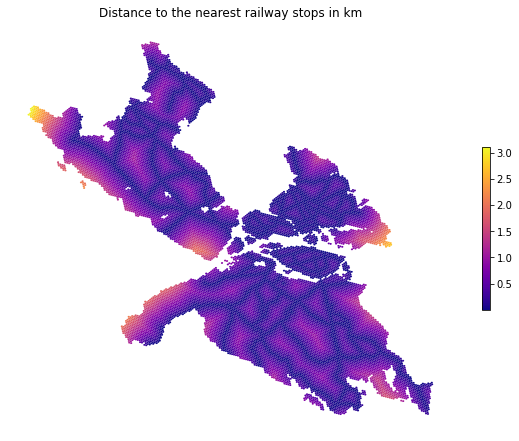

In [ ]:
# Plot distance from h3.centroid to nearest railway stops

ax = features_h3.plot(figsize=(10, 10),column='dist_cpri', cmap='plasma',
                   legend=True, legend_kwds={'shrink': 0.3})
ax.set_axis_off()
ax.set_title('Distance to the nearest railway stops in km')

In [ ]:
# Plot bus and train stops for GTFS
condition_dir = gtfs_stop_freq.dir_id == 'Inbound'
condition_window = gtfs_stop_freq.window == '0:00-24:00'
# фильтр в колонке dir_id по значению Inbound и в колонке window по '0:00-24:00'
gdf = gtfs_stop_freq.loc[(condition_dir & condition_window), : ].set_index('stop_id') 
gtfs.map_gdf(gdf=gdf, 
             variable='dir_id', 
             tooltip_var=['frequency', 'stop_id'],
             tooltip_labels = ['Frequency: ', 'Stop: '])

In [ ]:
# Plot regso
# Plot boundares of districs on the Map
fig = Figure(width='40%', height=500)
m = folium.Map(location=[59.30, 18.14], zoom_start=9, tiles="OpenStreetMap")
for _, r in regso.iterrows():  #districts.query('LAGSTA_NIVA=="Fjölebro"').iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry'])#.simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['kommunregs']).add_to(geo_j)
    geo_j.add_to(m)
    fig.add_child(m)
m

In [ ]:
# Plot regso
# Plot boundares of districs on the Map
fig = Figure(width='40%', height=500)
m = folium.Map(location=[59.30, 18.14], zoom_start=9, tiles="OpenStreetMap")
for _, r in railway_stop.to_crs(4326).iterrows():  #districts.query('LAGSTA_NIVA=="Fjölebro"').iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry'])#.simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['stop_name']).add_to(geo_j)
    geo_j.add_to(m)
    fig.add_child(m)
m

In [ ]:
# Plot cycle on the map
gdf = cycle
gtfs.map_gdf(gdf=gdf, 
             variable='main_attribute_value', 
             tooltip_var=['main_attribute_value'],
             tooltip_labels = ['atr:'])

In [ ]:
# Plot city_w
gdf = city_w
gtfs.map_gdf(gdf=gdf, 
             variable='vattenforekomst', 
             tooltip_var=['vattenforekomst'],
             tooltip_labels = ['atr:'])